## Análise preliminar

### Bibliotecas

In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=2):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

### Base de dados

A base de dados dessa análise preliminar contém todos os dados descritos na "introdução" deste documento.

In [2]:
object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

estilo_tabelas(df_eventos.head(5))

,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,codigo_ibge,Setores Censitários,Status,DH_Descricao,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Descricao,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,DA_Descricao,DA_Polui/cont da água,DA_Polui/cont do ar,DA_Polui/cont do solo,DA_Dimi/exauri hídrico,DA_Incêndi parques/APA's/APP's,PEPL_Descricao,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Descricao,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,Município - UF,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Categoria,Grupo,Subgrupo,Tipo,Subtipo,COBRADE,Pop
0,SP-A-3550001-12200-20100101,São Luiz do Paraitinga,SP,Sudeste,2010-01-01,2010-01-01,3550001,nan,Reconhecido,nan,0,0,0,93,4030,0,16,4139,nan,49,20,20643486.93,3.00,0,1121928.64,9.00,1,5235666.98,0,0,0.00,3,3,32411.27,25.00,0.00,65321178.46,92354672.28,nan,nan,nan,nan,nan,nan,nan,7978.16,673157.18,623293.69,2493.17,0.00,330993.88,3739.76,58609.55,0.00,0.00,1087024.19,2787289.59,nan,1642902.43,1149353.56,379785.31,0.00,24433.11,3196474.42,5983764.00,2010,nan,nan,nan,São Luiz do Paraitinga - SP,86448.00,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Enxurradas,nan,nan,12200,10397.00
1,SP-A-3518305-11321-20100101,Guararema,SP,Sudeste,2010-01-01,2010-01-01,3518305,nan,Reconhecido,nan,4,2,0,66,417,0,14430,14919,nan,161,91,18604069.99,0.00,0,0.00,2.00,0,24931.75,0,0,0.00,0,0,37397.62,9000.00,0.00,57771845.31,76438244.67,nan,nan,nan,nan,nan,nan,nan,0.00,179508.58,264276.52,12465.87,0.00,349044.47,74795.24,134631.44,0.00,0.00,77288.42,1092010.54,nan,441291.93,2049389.64,0.00,0.00,112192.89,2602874.46,3694885.00,2010,nan,nan,nan,Guararema - SP,1111405.00,nan,nan,nan,nan,nan,nan,Natural,Geológico,Movimento de massa,Deslizamentos,Deslizamentos de solo e ou rocha,11321,25844.00
2,BA-A-2905909-14110-20100101,Campo Alegre de Lourdes,BA,Nordeste,2010-01-01,2010-01-01,2905909,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.00,0.00,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,747.95,448771.46,0.00,0.00,0.00,0.00,0.00,249317.48,0.00,0.00,177015.41,875852.29,nan,254303.82,147097.31,0.00,0.00,0.00,401401.13,1277253.42,2010,nan,9.64,2914.59,Campo Alegre de Lourdes - BA,107459.00,nan,nan,nan,nan,nan,nan,Natural,Climatológico,Seca,Estiagem,nan,14110,28090.00
3,SP-A-3513603-12100-20100101,Cunha,SP,Sudeste,2010-01-01,2010-01-01,3513603,nan,Reconhecido,nan,6,0,0,38,492,0,12000,12536,nan,89,9,3340854.17,0.00,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0.00,3.00,400.00,8052097.61,11392951.78,nan,nan,nan,nan,nan,nan,nan,0.00,1246.59,0.00,0.00,0.00,1994539.80,0.00,125656.01,0.00,0.00,0.00,2121442.40,nan,49863.50,1383711.99,0.00,0.00,925466.47,2359041.95,4480484.34,2010,nan,15.54,1407.25,Cunha - SP,112225.00,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Inundações,nan,nan,12100,21866.00
4,BA-P-2917334-12200-20100101,Iuiu,BA,Nordeste,2010-01-01,2010-01-01,2917334,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.00,0.00,0,0.00,0.00,0,0.00,0,0,0.00,0,0,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00

### Tipo de variável

In [3]:
df_eventos_tipo = df_eventos.dtypes.reset_index().rename(columns={0: 'Tipo', 'index': 'Variável'})
estilo_tabelas(df_eventos_tipo)

,Variável,Tipo
0,Protocolo_S2iD,object
1,Nome_Municipio,object
2,Sigla_UF,object
3,regiao,object
4,Data_Registro,object
5,Data_Evento,object
6,codigo_ibge,int64
7,Setores Censitários,object
8,Status,object
9,DH_Descricao,object


### Estatísticas descritivas

In [4]:
estilo_tabelas(df_eventos.describe())

,codigo_ibge,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,COBRADE,Pop
count,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,26258.00,4024.00,16907.00,19171.00,20443.00,13170.00,13170.00,13170.00,13170.00,13170.00,13170.00,26258.00,23244.00
mean,3159209.61,0.10,2.32,32.26,36.07,163.13,0.05,6527.96,6761.89,70.16,11.31,1424283.15,0.55,10.42,36069.60,0.57,0.12,70572.43,0.05,0.09,12734.64,0.58,0.20,37174.81,863.76,190472.76,1456701.51,3037536.14,65368.55,806901.06,149728.24,51488.54,7935.83,18068.69,4536.81,370284.83,7895.06,12323.81,53594.44,1548125.86,8566347.27,2599208.59,333617.51,1972882.46,378106.03,13850161.86,15398287.71,2017.40,1438987.95,78.63,1974.95,848257.06,0.37,0.30,0.45,0.24,0.15,1015.53,13578.60,33492.02
std,918980.83,3.60,67.38,421.66,409.86,1274.63,3.03,30912.35,31125.61,771.94,343.38,51175714.44,10.87,187.08,597770.30,3.80,1.50,1120454.14,0.76,1.22,583173.53,18.84,13.22,642217.44,115578.38,30855968.42,14311996.38,59569863.08,1389175.85,8651393.19,4075078.90,649395.12,217727.19,243492.73,153784.53,4281597.81,267610.40,601226.25,628209.07,11429204.38,39525545.45,12352086.87,6606823.35,91786610.91,8349024.83,105653327.35,106948387.08,4.04,5179809.05,361.17,7237.32,9386767.88,0.22,0.22,0.32,0.20,0.16,4174.12,966.58,178125.77
min,1100015.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2010.00,0.00,0.03,25.70,-19046.00,0.00,0.00,0.00,0.00,0.00,1.00,11110.00,822.00
25%,2504405.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31726.37,2014.00,124264.25,12.06,213.73,66273.00,0.18,0.13,0.15,0.07,0.02,85.00,13214.00,6091.75
50%,2930766.00,0.00,0.00,0.00,0.00,0.00,0.00,1927.50,2090.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77211.63,467150.53,21983.29,0.00,0.00,0.00,1381849.16,2370182.58,2018.00,358947.19,23.85,467.91,140520.00,0.35,0.26,0.41,0.21,0.10,236.00,14110.00,12534.00
75%,4203006.00,0.00,0.00,0.00,0.00,0.00,0.00,6146.75,6500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,127281.44,582294.01,0.00,149590.49,0.00,0.00,0.00,0.00,0.00,0.0

### Registros

Protocolos duplicados: não foram localizados protocolos duplicados

In [5]:
df_eventos["Protocolo_S2iD"].duplicated().sum()

np.int64(0)

Protocolos por ano:

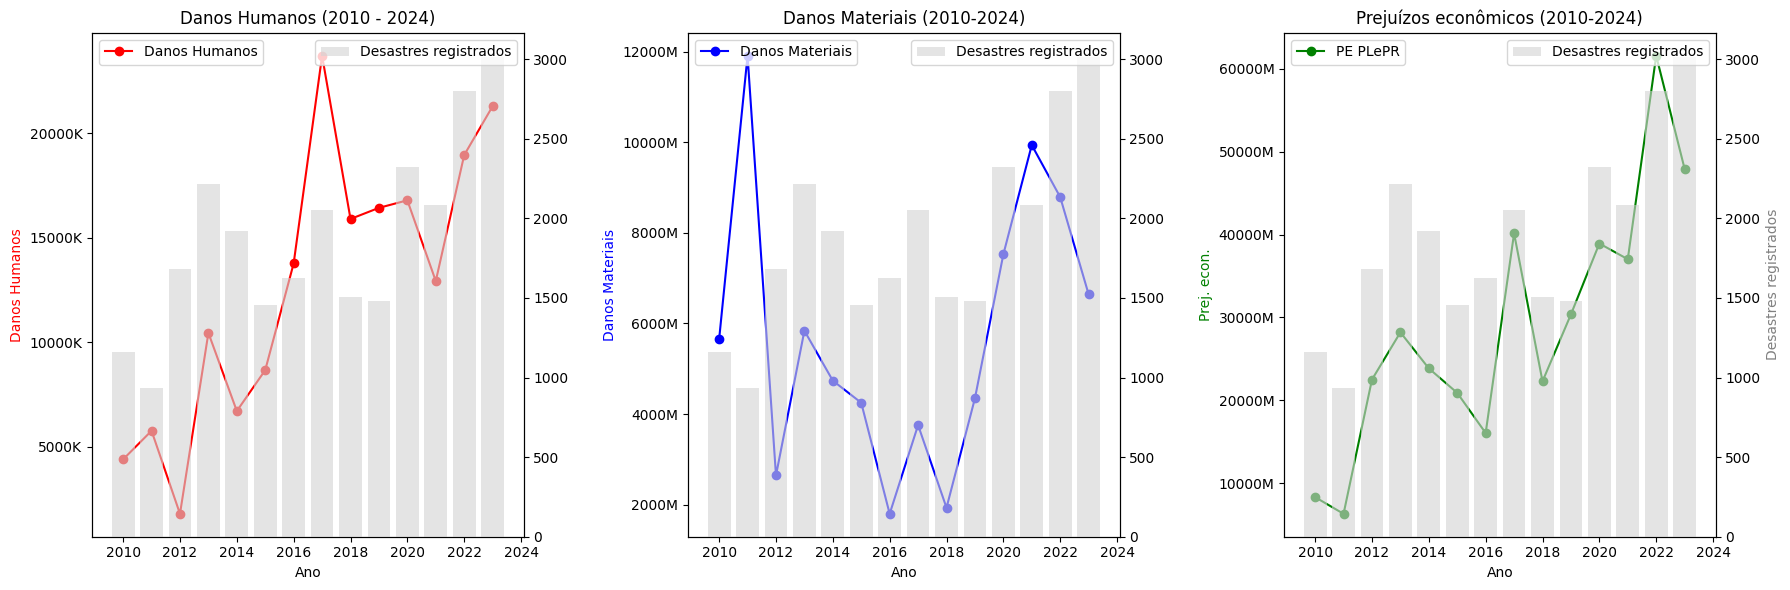

In [6]:
# Dados agrupados por ano
df_eventos_temporal = df_eventos.groupby('Ano_Evento').agg({
    'DH_total_danos_humanos': 'sum',
    'DM_total_danos_materiais': 'sum',
    'PE_PLePR': 'sum',
    'Protocolo_S2iD': 'count'  # Contagem de ocorrências de Protocolo_S2_iD
}).reset_index()

def formatar_milhar(x, pos):
    return '%1.0fK' % (x * 1e-3)

def formatar_milhao(x, pos):
    return '%1.0fM' % (x * 1e-6)

# Criação da figura com três subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico 1: Danos Humanos
ax1 = axs[0]
ax2 = ax1.twinx()  # Eixo y secundário

ax1.plot(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['DH_total_danos_humanos'], color='red', label='Danos Humanos', marker='o')
ax2.bar(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['Protocolo_S2iD'], color='lightgrey', label='Desastres registrados', alpha=0.6)

ax1.set_xlabel('Ano')
ax1.set_ylabel('Danos Humanos', color='red')
ax2.set_ylabel(' ', color='grey')

ax1.set_title('Danos Humanos (2010 - 2024)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.yaxis.set_major_formatter(FuncFormatter(formatar_milhar))

# Gráfico 2: Danos Materiais
ax3 = axs[1]
ax4 = ax3.twinx()  # Eixo y secundário

ax3.plot(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['DM_total_danos_materiais'], color='blue', label='Danos Materiais', marker='o')
ax4.bar(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['Protocolo_S2iD'], color='lightgrey', label='Desastres registrados', alpha=0.6)

ax3.set_xlabel('Ano')
ax3.set_ylabel('Danos Materiais', color='blue')
ax4.set_ylabel(' ', color='grey')

ax3.set_title('Danos Materiais (2010-2024)')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

ax3.yaxis.set_major_formatter(FuncFormatter(formatar_milhao))

# Gráfico 3: PE PLePR
ax5 = axs[2]
ax6 = ax5.twinx()  # Eixo y secundário

ax5.plot(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['PE_PLePR'], color='green', label='PE PLePR', marker='o')
ax6.bar(df_eventos_temporal['Ano_Evento'], df_eventos_temporal['Protocolo_S2iD'], color='lightgrey', label='Desastres registrados', alpha=0.6)

ax5.set_xlabel('Ano')
ax5.set_ylabel('Prej. econ.', color='green')
ax6.set_ylabel('Desastres registrados', color='grey')

ax5.set_title('Prejuízos econômicos (2010-2024)')
ax5.legend(loc='upper left')
ax6.legend(loc='upper right')

ax5.yaxis.set_major_formatter(FuncFormatter(formatar_milhao))

# Ajuste do layout
plt.tight_layout()
plt.show()


### Correlação entre as features

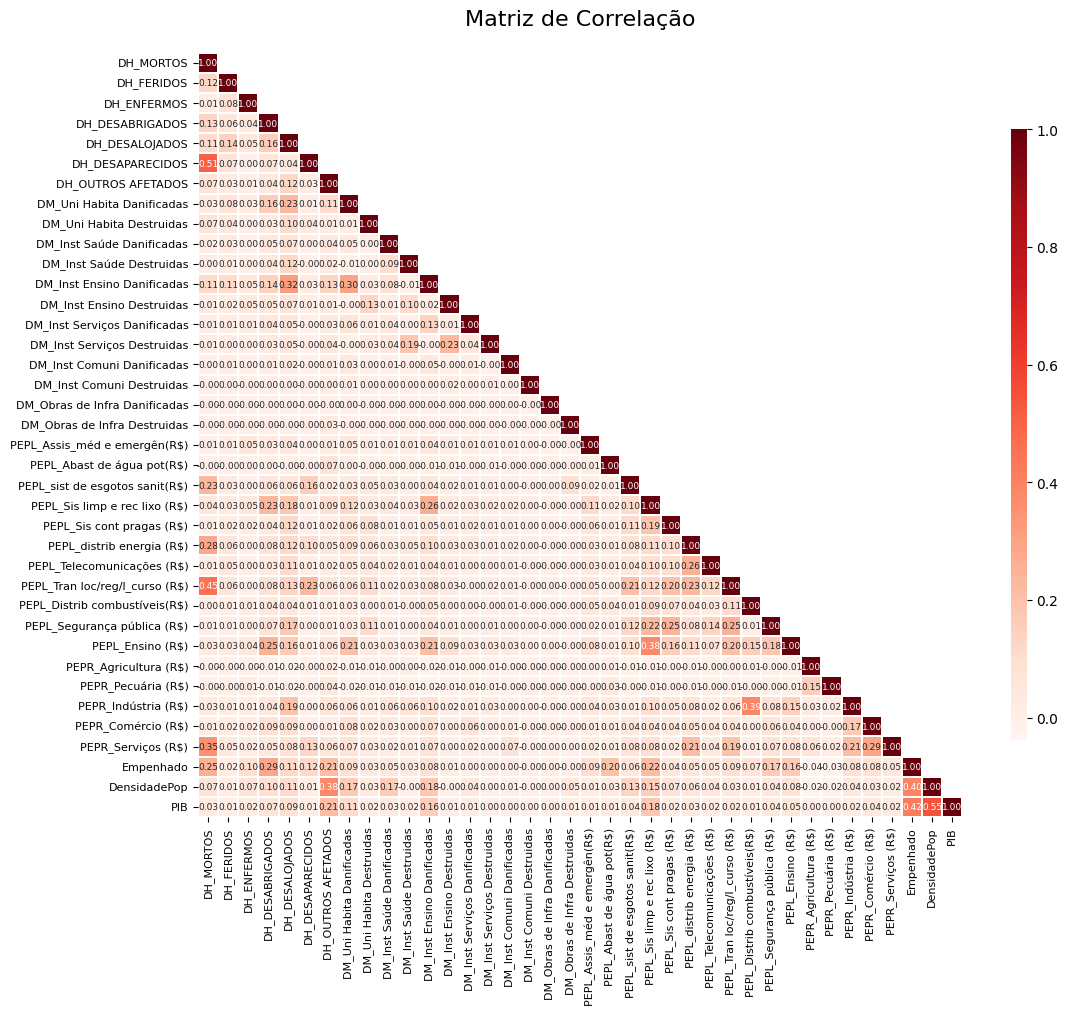

In [7]:
# Correlação entre as variáveis independentes

variaveisnum_todas = [
    'DH_MORTOS', 'DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS', 'DH_DESAPARECIDOS', 'DH_OUTROS AFETADOS',
    'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas',  
    'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 
    'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Destruidas',  
    'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas',  
    'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas',  
    'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 
    'PEPL_Assis_méd e emergên(R$)', 'PEPL_Abast de água pot(R$)', 'PEPL_sist de esgotos sanit(R$)', 
    'PEPL_Sis limp e rec lixo (R$)', 'PEPL_Sis cont pragas (R$)', 'PEPL_distrib energia (R$)', 
    'PEPL_Telecomunicações (R$)', 'PEPL_Tran loc/reg/l_curso (R$)', 'PEPL_Distrib combustíveis(R$)', 
    'PEPL_Segurança pública (R$)', 'PEPL_Ensino (R$)', 'PEPR_Agricultura (R$)', 
    'PEPR_Pecuária (R$)', 'PEPR_Indústria (R$)', 'PEPR_Comércio (R$)', 'PEPR_Serviços (R$)',
    'Empenhado', 'DensidadePop', 'PIB'
]

df_corr_todas = df_eventos[variaveisnum_todas]

correlacao_todas = df_corr_todas.corr()

mask = np.triu(np.ones_like(correlacao_todas, dtype=bool), k=1)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    correlacao_todas, 
    cmap="Reds", 
    annot=True,
    fmt=".2f",
    linewidths=0.2, 
    linecolor='white',
    cbar_kws={"shrink": 0.8, "aspect": 40},
    square=True,
    mask=mask,
    annot_kws={"size": 6.5},
)
plt.title('Matriz de Correlação', fontsize=16, pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

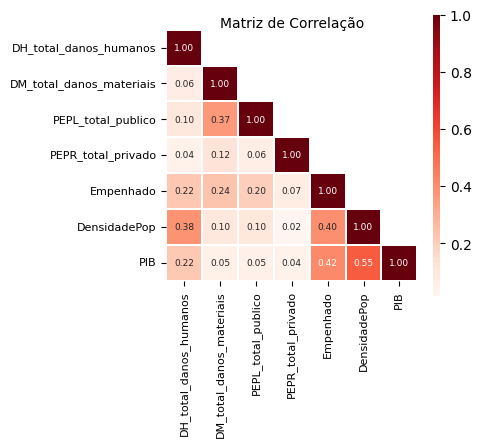

In [8]:
variaveisnum_selecionadas = [
    'DH_total_danos_humanos', 'DM_total_danos_materiais', 'PEPL_total_publico', 'PEPR_total_privado', 'Empenhado', 'DensidadePop', 'PIB'
]

df_corr_selecionadas = df_eventos[variaveisnum_selecionadas]

correlacao_selecionadas = df_corr_selecionadas.corr()

mask = np.triu(np.ones_like(correlacao_selecionadas, dtype=bool), k=1)

plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(
    correlacao_selecionadas, 
    cmap="Reds", 
    annot=True,
    fmt=".2f",
    linewidths=0.2, 
    linecolor='white',
    cbar_kws={"shrink": 0.8, "aspect": 40},
    square=True,
    mask=mask,
    annot_kws={"size": 6.5},
)
plt.title('Matriz de Correlação', fontsize=10, pad=2)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

### Balanceamento da variável 'target'

Há desbalanceamento entre o status "Reconhecido" e "Não reconhecido", o qual deverá ser tratado na etapa de pré-processamento dos dados.

In [9]:
status_counts = df_eventos['Status'].value_counts()
print("\nDistribuição da variável 'Status':")
display(status_counts)


Distribuição da variável 'Status':


Status
Reconhecido        23871
Não reconhecido     2387
Name: count, dtype: int64

### Dados ausentes

Existem variáveis com quantidade de dados ausentes superior a 50%. Essas variáveis serão tratadas no pré-processamento.

In [10]:
df_na_counts = df_eventos.isna().sum().reset_index().rename(columns={0: 'Qtde. dados ausentes', 'index': 'Variável'})
df_na_counts['% de dados ausentes'] = (df_na_counts['Qtde. dados ausentes'] / len(df_eventos)) * 100
df_na_counts['Qtde. dados ausentes'] = df_na_counts['Qtde. dados ausentes'].astype(int)
df_na_counts = df_na_counts.sort_values(by='% de dados ausentes', ascending=False)
estilo_tabelas(df_na_counts)

,Variável,Qtde. dados ausentes,% de dados ausentes
40,DA_Polui/cont do ar,26125,99.49
41,DA_Polui/cont do solo,25903,98.65
39,DA_Polui/cont da água,25283,96.29
43,DA_Incêndi parques/APA's/APP's,24921,94.91
42,DA_Dimi/exauri hídrico,24580,93.61
66,Empenhado,22234,84.68
81,Subtipo,20011,76.21
75,PDEFSAN,13088,49.84
73,PDEFESGOTO,13088,49.84
72,PDEFAGUA,13088,49.84
